#Install Packages

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shivamb/real-or-fake-fake-jobposting-prediction

 99% 16.0M/16.1M [00:01<00:00, 18.1MB/s]
100% 16.1M/16.1M [00:01<00:00, 10.0MB/s]


In [ ]:
!unzip /content/real-or-fake-fake-jobposting-prediction.zip

Archive:  /content/real-or-fake-fake-jobposting-prediction.zip
  inflating: fake_job_postings.csv   


#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
df = pd.read_csv('fake_job_postings.csv')

In [ ]:
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
df.shape

(17880, 18)

In [ ]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<ipython-input-15-1b325da5c485>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
<ipython-input-15-1b325da5c485>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)


<Axes: >

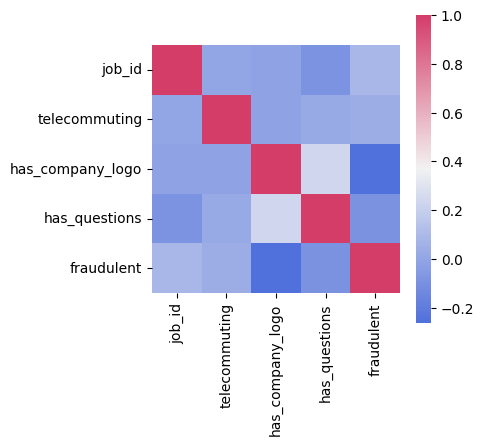

In [ ]:
plt.figure(figsize = (4,4))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [ ]:
df.drop(labels=['job_id','salary_range'],axis=1,inplace=True)

In [ ]:
df.shape

(17880, 16)

In [ ]:
df.fillna(" ",inplace = True)

In [ ]:
df.isnull().sum()

title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

In [ ]:
df.head(2)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0


In [ ]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' '+ df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']+' '+df['employment_type'] + ' ' + df['required_experience'] + ' '+df['required_education'] +' '+ df['industry'] + ' '+df['function']

In [ ]:
df.text[2]

"Commissioning Machinery Assistant (CMA) US, IA, Wever   Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry.\xa0Valor Services will be involved with you throughout every step of the hiring process and remain in contact with you all the way through the final step of signing of the employment contract with your new employer.\xa0Valor Services was founded with the vision of employing the unique skills, experiences, and qualities of America’s finest veterans to provide Private Sector companies with precise and concerted value-added services – and America’s finest Veterans with an optimized career opportunity.We are eager to get the word out to veterans that there are ample opportunities for employment in the private sector and that you are the ideal candidates to fill those positions.\xa0Valor Services\xa0Your Success is Our Mission.\xa0™\xa0 Our client, located in Houston, is actively s

In [ ]:
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['telecommuting']
del df['has_company_logo']
del df['has_questions']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']

In [ ]:
df.head(2)

,fraudulent,text
0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,"Customer Service - Cloud Video Production NZ, ..."


#Data Cleaning

In [ ]:
pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-5y9iypkm
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-5y9iypkm
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=0a43fda152b250a031333ac3568b36437f8714b272665a2892bbacdde4760502
  Stored in directory: /tmp/pip-ephem-wheel-cache-2nlwzhpg/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)

    return x

In [ ]:
df['text']=df['text'].apply(lambda x: get_clean(x))

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


<Axes: xlabel='fraudulent', ylabel='count'>

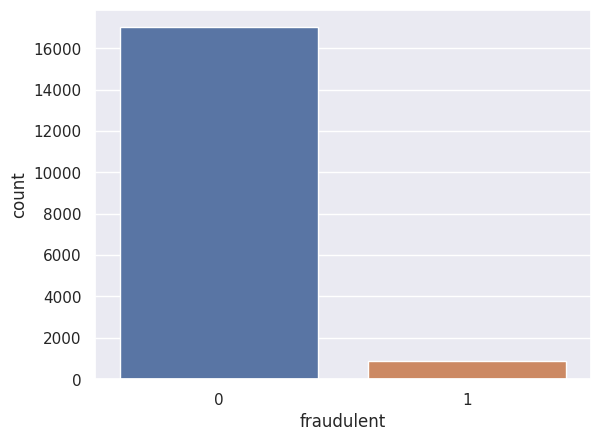

In [ ]:
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = df)

In [ ]:
df.text[2]

'commissioning machinery assistant cma us ia wever valor services provides workforce solutions that meet the needs of companies across the private sector with a special focus on the oil gas industry valor services will be involved with you throughout every step of the hiring process and remain in contact with you all the way through the final step of signing of the employment contract with your new employer valor services was founded with the vision of employing the unique skills experiences and qualities of americas finest veterans to provide private sector companies with precise and concerted valueadded services and americas finest veterans with an optimized career opportunitywe are eager to get the word out to veterans that there are ample opportunities for employment in the private sector and that you are the ideal candidates to fill those positions valor services your success is our mission TM our client located in houston is actively seeking an experienced commissioning machinery

In [ ]:
df['Word Count']=df['text'].apply(lambda x: len(x.split()))

In [ ]:
df['text'].to_csv("Sample")

#Model Building

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf=TfidfVectorizer()
X=tfidf.fit_transform(df['text'])

In [ ]:
X=X.toarray()

In [ ]:
X.shape

(17880, 162687)

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, df['fraudulent'], test_size=0.2, random_state=12342, stratify=df['fraudulent'])
X_train.shape, X_test.shape

((14304, 162687), (3576, 162687))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
lr=LogisticRegression()
nb=MultinomialNB()
svc=SVC(kernel='linear', probability=True)
rf=RandomForestClassifier()

In [ ]:
def model_training(X_train,X_test,y_train,y_test,model,text):
   model.fit(X_train,y_train)
   y_pred=model.predict(X_test)
   print(text)
   print(metrics.confusion_matrix(y_test,y_pred))
   print(metrics.classification_report(y_test,y_pred))
   predict_prob=model.predict_proba(X_test)
   print("AUC ROC")
   print(metrics.roc_auc_score(y_test, predict_prob[:,1]))

In [ ]:
%%time
model_training(X_train,X_test,y_train,y_test,lr,'Logistric Regression')

Logistric Regression
[[3402    1]
 [ 104   69]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3403
           1       0.99      0.40      0.57       173

    accuracy                           0.97      3576
   macro avg       0.98      0.70      0.78      3576
weighted avg       0.97      0.97      0.96      3576

AUC ROC
0.9814699372705824
CPU times: user 5min 16s, sys: 1min 10s, total: 6min 26s
Wall time: 35.1 s


In [ ]:
%%time
model_training(X_train,X_test,y_train,y_test,nb,'Multinomial NB')

Multinomial NB
[[3403    0]
 [ 173    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3403
           1       0.00      0.00      0.00       173

    accuracy                           0.95      3576
   macro avg       0.48      0.50      0.49      3576
weighted avg       0.91      0.95      0.93      3576



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC ROC
0.852308147010713
CPU times: user 14.4 s, sys: 3.31 s, total: 17.8 s
Wall time: 4.82 s


In [ ]:
%%time
model_training(X_train,X_test,y_train,y_test,rf,'Random Forest')

Random Forest
[[3403    0]
 [  64  109]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       1.00      0.63      0.77       173

    accuracy                           0.98      3576
   macro avg       0.99      0.82      0.88      3576
weighted avg       0.98      0.98      0.98      3576

AUC ROC
0.9857894853062326
CPU times: user 10min 17s, sys: 2.73 s, total: 10min 19s
Wall time: 10min 17s


In [ ]:
%%time
model_training(X_train,X_test,y_train,y_test,svc,'SVC')

SVC
[[3399    4]
 [  56  117]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.97      0.68      0.80       173

    accuracy                           0.98      3576
   macro avg       0.98      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

AUC ROC
0.9819081769061301
CPU times: user 11h 10min 4s, sys: 4h 17min 27s, total: 15h 27min 32s
Wall time: 1h 19min 12s
